# River network problem with multiple watersheds
## Setup

In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
from scipy.optimize import minimize
import random
import time


import scipy.interpolate as interpolate
from scipy.misc import derivative 
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import pandas as pd


## Trisection method / Golden section search

* Suppose we have a function f(x), find x’ such that f(x’) is a maximum of the function f(x) over an interval [a,b].
* If f(x) is a concave, what we find is the global maximum; otherwise, it may be just a local maximum.

149.99999866586523
149.99999866586523


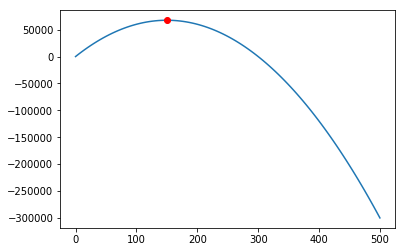

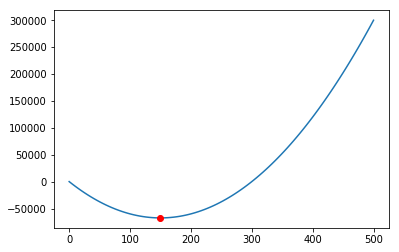

In [17]:
phi = (math.sqrt(5) + 1) / 2 # golden ratio

def gss(f, a, b, mode='max', tol=1e-8):
    """
    Golden section search to find the maximum or minimum of f on [a,b]
    Inputs:
        f          a strictly unimodal function on [a,b]
        a          starting value of the search interval
        b          closing value of the search interval
        mode       either 'max' to find maximum, or 'min' to find minimum
        tol        tolerance for the solution
    Return (tuple):
        lam        learned dual variable vector (1d numpy array -- length num_species)
        g_history  dual function in iteration (1d numpy array -- length iters)
    """
    map = dict()
    c = b - (b - a) / phi
    d = a + (b - a) / phi 
    while abs(c - d) > tol:
        if (c not in map):
            map[c] = f(c)
        if (d not in map):
            map[d] = f(d)
        if ((mode == 'min' and map[c] < map[d]) 
            or (mode == 'max' and map[c] > map[d])):
            b = d
            d = c
            c = b - (b - a) / phi
        else:
            a = c
            c = d
            d = a + (b - a) / phi

    return (b + a) / 2

''' Test gss '''
x = np.linspace(0, 500, 100) 

# test finding maximum
f = lambda x: -3*x**2 + 900*x + 1
y = f(x)
plt.plot(x,y)
x_prime = gss(f, 0, 500, 'max') # value of x at maximum of f in range [0, 500]
print (x_prime) # should print ~150
plt.plot(x_prime, f(x_prime), 'ro')

# test finding minimum
f = lambda x: 3*x**2 - 900*x - 1
y = f(x)
plt.figure()
plt.plot(x,y)
x_prime = gss(f, 0, 500, 'min') # value of x at minimum of g in range [0, 500]
print (x_prime) # should print ~150
plt.plot(x_prime, f(x_prime), 'ro')


## Code for solving the optimization problem

In [18]:
'''ADMM'''
# add a or A as parameter, should not be used as global variable 
#TODO: take everything as parameter includng a and b and roi 
def dual_update(X, S, y, p, iters, x_max):
    start_time1 = time.time()
    L_history = np.zeros(iters)
    first_deriv_copy = np.zeros(iters)
    
    #num_iters_ran = 0

    for r in range(iters):            
        #print(first_deriv[r])
        if r in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50):             
            print('round = ', r, ' takes', (time.time() - start_time1), ' seconds \n')
            start_time1 = time.time()
                
        for j in range(num_watersheds_total):
            
            '''
            x_correct_func = lambda x: x-roi[j](x)*np.dot(y,a[:,j])+(p/2)*np.power(roi[j](x),2)*np.dot(a[:,j].T, a[:,j])-p*roi[j](x)*for_species(p,X,S,j)
            x_func = lambda x: x - np.dot((y + p*b + p*S), a[:][j]*roi[j](x)) + (p/2)*np.power(np.linalg.norm(a[:][j]*roi[j](x)), 2)
            X[j] = gss(x_correct_func, 0, x_max, 'min')
            '''
            # using scipy.minimize to see if it gets any faster...
            # yeah... by 45 seconds (when rho = 400)
            
            def x_func(x):
                return x-roi[j](x)*np.dot(y,a[:,j])+(p/2)*np.power(roi[j](x),2)*np.dot(a[:,j].T, a[:,j])-p*roi[j](x)*for_species(p,X,S,j)
           
            bnd_x = (0., x_max)
            bndx = (bnd_x,)*1
            x_init = [0]
            opt = {'maxiter':200} # set max # of iterations 
            solx = minimize(x_func, x_init, bounds = bndx, options = opt)
            X[j] = solx.x[0]
            
        
        # roi[j] is a function, (X[j]) is the x coordinate value taken by this function
        f = np.array([roi[j](X[j]) for j in range(num_watersheds_total)])
        Af = np.dot(a, f)
        for i in range(num_species):
            '''
            s_func = lambda s: ((y[i] + p*(b[i] - Af[i]))*s + (p/2)*s*s)
            S[i] = gss(s_func, 0, x_max, 'min')
            '''
            
            # using scipy.minimize to see if it gets any faster...
            # yeah... by 45 seconds (rho = 400)

            def s_func(s):
                return ((y[i] + p*(b[i] - Af[i]))*s + (p/2)*s*s)
           
            bnd_s = (0., x_max)
            bnds = (bnd_s,)*1
            s_init = [0]
            opt = {'maxiter':200} # set max # of iterations 
            sols = minimize(s_func, s_init, bounds = bnds, options = opt)
            S[i] = sols.x[0]
            
        
        y += p*(b - Af + S)
        L_history[r] = np.sum(X) + np.dot(y, (b - Af + S)) + (p/2)*np.power(np.linalg.norm(b - Af + S), 2)
        #print("Round", r, ":", L_history[r])
        if(r >= 2):
            first_deriv_copy[r-2]=(L_history[r-1]-L_history[r-2])/(L_history[r-2])
            #print("Round", r, ":", (L_history[r-1]-L_history[r-2])/(L_history[r-2]))
            #print(first_deriv_copy[r-2])
            if((first_deriv_copy[r-2]<=1e-5) & (first_deriv_copy[r-2]>=-1e-5)):
                #num_iters_ran = r-2
                #print('linh tinh')
                break
                
        #if (p < 350):
        #    p = p * 2
  
    return X, S, y, L_history

# returns SCALAR, rename, explain each line, 
# explain each line down in latex 
def for_species(p,X,S,j):   
    sum=0
    for i in range(num_species):
        w=a[i,j]
        q = np.array([roi[h](X[h]) for h in range(num_watersheds_total)])
        z=np.dot(a[i,:],q)
        v=w*(b[i]+S[i]-z + roi[j](X[j])*a[i,j] )
        sum=sum+v
    #sum=p*roi[j](X[j])*sum
    return sum

$g(\lambda^*,\nu^*) = d^* = p^*$.

Check for shape of matrices. A[:][1] and A[:,1] are different

In [19]:
A = np.arange(12).reshape((3,4))

B=np.array([100,101,102])
print(A)
print(A[1][:])
print(A[1,2])


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[4 5 6 7]
6


## Toy problem
* Read watershed's ROI data from a file
* Pre-process the ROI curves to make them concave
* Set up a toy problem with 3 watersheds & 3 species
* Use gradient ascent to find dual variables
* Use dual variables to find X that minimizes the Lagrangian function
* Verify that X satisfies the habitat target constraints

watershed data 0
coeffs: [ 0.00840583 -0.11299362  0.42035572  0.44853454]
watershed data 1
coeffs: [-0.00407338  0.13810581 -0.56246479  0.3696556 ]
watershed data 2
coeffs: [-0.01394591  0.36765222 -1.72139265  1.18553684]


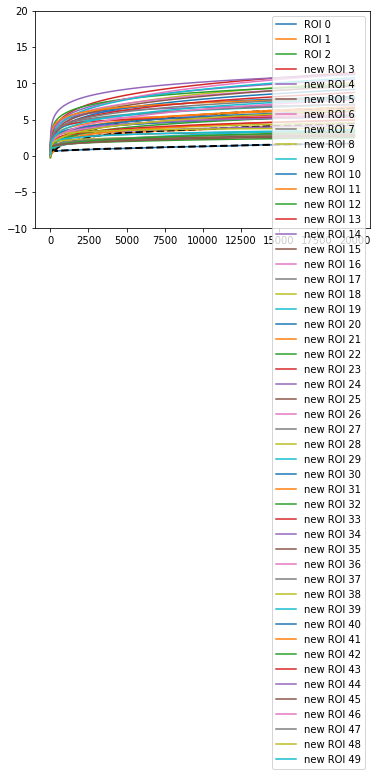

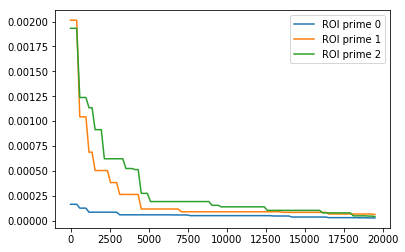

In [20]:
'''
Loads the data from file
'''


data = pd.read_csv('watershed_data.csv', sep=',',header=None).values
# % Data columns
# %
# % 0 - tree root, which represents a watershed number
# % 1 - budget given to the RDP algorithm (range from 0 to 20000, step = 500) 
# % 2 - budget used by RDP
# % 3 - policy(habitat) value of the solution given by RDP

scale = 1e6
data[:,3] = data[:,3]/scale

# get unique watershed id's without sorting
helper_indexes = np.unique(data[:,0], return_index=True)[1]
wts_id = np.array([data[:,0][index] for index in sorted(helper_indexes)])
num_watersheds = len(wts_id)
num_watersheds_total = 50 #total number of watersheds including made-up roi curves 

roi = np.empty(num_watersheds_total, dtype=object)
roi_prime = np.empty(num_watersheds_total, dtype=object)
concave_roi = np.empty(num_watersheds, dtype=object)


coeffs = np.empty(shape=(3,4)) # hold polynomial fit coefficients of the 3 roi curves

x = np.linspace(0, 19500, 100)
# TODO: store vertices as array of sequences than overriding 

# roi[j] - function that takes in money invested in watershed j and returns expected total habitat
for j in range(num_watersheds):
    # get the ROI curve for each watershed
    wts_data = data[np.where(data[:, 0] == wts_id[j])]
    x_axis=np.array(wts_data[:, 2])
    x_axis[0] = 1.5
    
    log_x_axis = np.log(x_axis)
    y_axis=np.array(wts_data[:, 3])
    print("watershed data", j)
    
    p = np.poly1d(np.polyfit(log_x_axis, y_axis, 3))
    
    
    coeffs[j] = p.c # get coefficients of the polynomial fit p
    print('coeffs:', coeffs[j])
    #print(np.polyfit(x_axis,y_axis, 3))
    #one, two, three, four, five=np.polyfit(np.square(x_axis), x_axis ,y_axis, 4)
    #abline_values = [one*i**4 +two*i**3+three*i**2+four*i+five for i in x_axis]
    #plt.plot(x_axis, abline_values, 'b')
    # roi[j] = interpolate.interp1d(wts_data[:, 2], wts_data[:, 3], fill_value='extrapolate')
    roi[j] = interpolate.interp1d(wts_data[:, 2], wts_data[:, 3])
    plt.plot(x, roi[j](x), label="ROI %d" % j)

    # compute the convex hull of the ROI curve and to get a convex upper bound
    hull = ConvexHull(wts_data[:, 2:])
    vertices = np.array(np.append(hull.vertices[1:], [0]))
    roi[j] = interpolate.interp1d(wts_data[vertices, 2], wts_data[vertices, 3], fill_value='extrapolate')
    roi_prime[j] = lambda x: derivative(roi[j], x, dx=1e-6)
    plt.plot(wts_data[vertices, 2], wts_data[vertices, 3], 'k--', lw=2) 

    
for j in range(num_watersheds,num_watersheds_total):
    roi_prime[j] = lambda x: derivative(roi[j], x, dx=1e-6)
    
    
plt.legend()



####################################################################
####################################################################
####################################################################

'''
Make up roi curves
'''
np.random.seed(2032)

testval_origin = False # check if new roi curve value at origin, i.e. log(1.1), is >= 0
test_increasing = False # check if new roi curve is an increasing function
test_not_toobig = roi[2](20000) + 100 # check if new roi curve value at 20000 is less than max roi[j](20000)+5
                              # to ensure that made-up roi curve is not too big compared to real roi of the 3 wts
new_roi_index = 0
#num_watersheds_total = 5

xvals = np.arange(0,20000,20)
xvals[0] = 1.5

log_xvals = np.log(xvals)
log_xvals[0] = np.log(0.2)
length_log_xvals = len(log_xvals)


for new_roi_index in range (num_watersheds,num_watersheds_total):
    while not (testval_origin == True and test_increasing == True and test_not_toobig < roi[2](20000) + 5):
        new_roi=np.array([np.random.uniform(np.amin(coeffs[:,0]), np.amax(coeffs[:,0])),
          np.random.uniform(np.amin(coeffs[:,1]), np.amax(coeffs[:,1])), 
          np.random.uniform(np.amin(coeffs[:,2]), np.amax(coeffs[:,2])), 
          np.random.uniform(np.amin(coeffs[:,3]), np.amax(coeffs[:,3]))])

        
   
        # check if new roi curve value at 20000 is less than max roi[j](20000)+5 
        # to ensure that made-up roi curve is not too big
        test_not_toobig = new_roi[0]*np.log(20000)**3 + new_roi[1]*np.log(20000)**2 + new_roi[2]*np.log(20000) + new_roi[3]

        # check if new roi curve value at origin, i.e. log(1.1), is >= 0
        testval_origin = True

        
        if (new_roi[0]*np.log(0.5)**3 + new_roi[1]*np.log(0.5)**2 + new_roi[2]*np.log(0.5) + new_roi[3] < 0):
            testval_origin = False
            break
        

        # ensure that first derivative at all values is > 0
        test_increasing = True

        for idx in range (0,length_log_xvals-1):
            val = log_xvals[idx]
            #if (3*new_roi[0]*val**2 + 2*new_roi[1]*val + new_roi[2] <= 0):
            if (3*1/np.exp(val)*new_roi[0]*val**2 + 2*1/np.exp(val)*new_roi[1]*val + 1/np.exp(val)*new_roi[2] <= 0.):
                test_increasing = False
                break 
    
    #print('testval_origin T/F: ', testval_origin)
    #print('test_increasing T/F: ', test_increasing)
    
    #print('\nnew_roi_index', new_roi_index)
    #print('\nnew roi:', new_roi, '\n')

    newyvals = new_roi[0]*log_xvals**3 + new_roi[1]*log_xvals**2 + new_roi[2]*log_xvals + new_roi[3]
    
    #save made up roi curve
    roi[new_roi_index] = lambda x: new_roi[0]*np.log(x+0.001)**3 + new_roi[1]*np.log(x+0.001)**2 + new_roi[2]*np.log(x+0.001) + new_roi[3]
    
    
    # plot the most recent made up ROI curves
    plt.plot(xvals,newyvals,label="new ROI %d" % new_roi_index) 
    plt.ylim(-10,20)
    plt.legend()
    
    testval_origin == False
    test_increasing == False
    test_not_toobig = roi[2](20000) + 100



# plot roi_prime in a new figure
plt.figure()
for j in range(num_watersheds):
    plt.plot(x, roi_prime[j](x), label="ROI prime %d" % j)
plt.legend()

## Experiment with Inverse Function

(0, 20000)

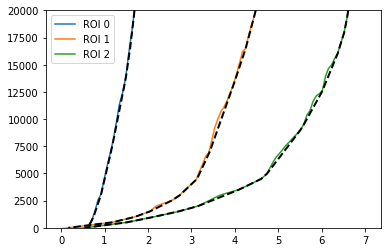

In [21]:
'''
Loads the data from file
'''
data = pd.read_csv('watershed_data.csv', sep=',',header=None).values
# % Data columns
# %
# % 0 - tree root, which represents a watershed number
# % 1 - budget given to the RDP algorithm (range from 0 to 20000, step = 500) 
# % 2 - budget used by RDP
# % 3 - policy value of the solution given by RDP

scale = 1e6
data[:,3] = data[:,3]/scale

wts_id = np.array([41587, 65629, 10987])
num_watersheds = len(wts_id)

roi_inverse = np.empty(num_watersheds, dtype=object)
concave_roi_inverse = np.empty(num_watersheds, dtype=object)

x = np.linspace(0, 7, 100)

# roi[j] - function that takes in money invested in watershed j and returns expected total habitat
for j in range(num_watersheds):
    # get the ROI curve for each watershed
    wts_data = data[np.where(data[:, 0] == wts_id[j])]
    roi_inverse[j] = interpolate.interp1d(wts_data[:, 3], wts_data[:, 2], fill_value='extrapolate')
    plt.plot(x, roi_inverse[j](x), label="ROI %d" % j)

    # compute the convex hull of the ROI curve and to get a convex upper bound
    hull = ConvexHull(wts_data[:, 2:])
    vertices_inverse = np.append(hull.vertices[1:], [0])
    roi_inverse[j] = interpolate.interp1d(wts_data[vertices_inverse, 3], wts_data[vertices_inverse, 2], fill_value='extrapolate')
    plt.plot(wts_data[vertices_inverse, 3], wts_data[vertices_inverse, 2], 'k--', lw=2) 

plt.legend()
plt.ylim([0, 20000])  ### NOTE: think about proper way to handle extrapolation

In [22]:
print(vertices) # actual vertices used to computer roi[2] 

[40 39 38 36 32 25 19 18 10  9  8  7  4  3  2  1  0]


In [23]:
'''
Toy problem with 3 watersheds and 3 species
'''

np.random.seed(6873480)

num_species = 50
num_watersheds = 3

# b[i] - habitat target for species i, b[i] >= 0

# The 3 lines of code below work, but need to find a way to fix a, where to set seed?

b = np.array([1.5e+06, 3.5e+06, 3e+06])/scale
b2 = np.random.randint(1,int(num_species*9/10), num_species - num_watersheds)
b = np.concatenate((b,b2), axis = None)


# for now, let use this b:
#b = np.array([1.5, 3.5, 3.,  5.,  6. , 5.5, 4.5, 6.5, 4, 8])

print('length b: ', len(b))
print('b is: ', b, '\n')

# a[i][j] = 1 if species i is available in watershed j, 0 otherwise


# this line below works, but need to find a way to fix a, where to set seed?
a = np.random.randint(2,size=(num_species, num_watersheds_total)) 


# for now let use this matrix a
'''
a = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 
              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
              [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
              [1, 0, 0, 1, 0, 0, 0, 1, 0, 1], 
              [0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
              [0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
              [1, 1, 0, 0, 0, 0, 0, 1, 1, 1]])
'''
              
print('a is: \n', a, '\n')

length b:  50
b is:  [ 1.5  3.5  3.   5.  24.  41.  26.   6.  31.   3.  27.  26.  11.  20.
 44.  42.  19.  12.   5.   6.  20.  37.  21.  38.   2.  26.   4.  42.
 43.  39.  33.  31.  37.  21.   6.  27.  43.  36.  24.  17.  42.  35.
  1.  28.  13.  16.  20.   8.  34.   5. ] 

a is: 
 [[0 0 0 ... 0 1 0]
 [1 1 0 ... 1 1 1]
 [0 1 0 ... 1 0 0]
 ...
 [0 1 0 ... 1 1 1]
 [1 1 1 ... 0 1 0]
 [1 1 0 ... 0 1 1]] 



round =  1  takes 32.24346685409546  seconds 

round =  2  takes 38.394365310668945  seconds 

round =  3  takes 41.590842962265015  seconds 

round =  4  takes 49.81528997421265  seconds 

round =  5  takes 55.1937198638916  seconds 

round =  6  takes 51.483421087265015  seconds 

round =  7  takes 61.61095905303955  seconds 

round =  8  takes 69.69860219955444  seconds 

round =  9  takes 64.39959287643433  seconds 

round =  10  takes 69.00312089920044  seconds 

round =  50  takes 24980.47797870636  seconds 

linh tinh
y is
[-8.23802055e-04  1.70880025e-02 -2.93332524e-03  3.85326587e-05
  4.01115340e-04 -7.39441997e-04  2.19335429e-04 -6.13656892e-04
  1.18533509e-04  1.38790726e-02  2.17545313e-04 -7.30146055e-04
 -2.84612228e-03 -3.83721428e-04 -8.04851254e-07  2.46409716e+01
 -2.54363481e-04 -4.76905407e-03  4.24720128e-05 -7.86427076e-03
 -2.49827851e-03 -2.35148461e-05  7.04196000e-04  5.63153719e-02
  1.45543389e-03 -4.32488368e-05 -2.86616403e-03 -2.07789979e-06
  6.76776

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


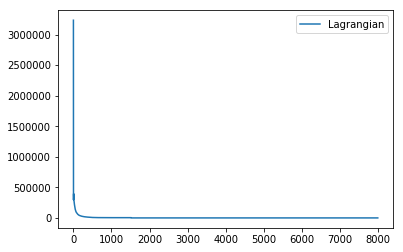

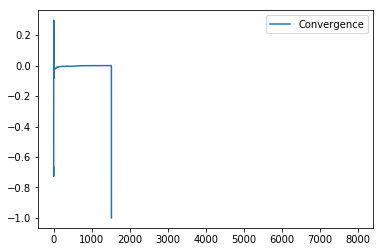

In [25]:
'''
Solve Toy problem using ADMM
'''
start_time = time.time()

iters = 8000
x_max = 20000


X = np.zeros(num_watersheds_total)
S = np.zeros(num_species)
y = np.zeros(num_species)
p = 400 # how to set p?
X, S, y, L_history = dual_update(X,S,y,p,iters,x_max)
print("y is")
print(y)


# Check convergence of the Lagrangian
# TODO: tolerance = 0.01% of avtual value
# how long takes to converge, neighbor 2 smaller than tolerance,slope between 2 points close to 0
print("L_history is: \n")
#print(L_history)
plt.figure()
plt.plot(L_history, label='Lagrangian')
plt.legend()

print("Convergence") # slope between 2 points close to 0 with 0.01 tolerance 
plt.figure()


first_deriv = np.zeros(iters)
for i in range (0,iters-1):
    first_deriv[i]=(L_history[i+1]-L_history[i])/(L_history[i])
# second_deriv = np.zeros(iters)
# for i in range (0,iters-1):
#     second_deriv[i]=(first_deriv[i+1]-first_deriv[i])/(first_deriv[i])
iters_to_optimal = -1                                                    
for i in range (0,iters-1):
    if((first_deriv[i]<=1e-5) & (first_deriv[i]>=-1e-5)):
        iters_to_optimal=i
        break
plt.plot(first_deriv, label='Convergence')
if(iters_to_optimal==-1):
    print("Not enough iteration to get optimal solution")
else:
    print("Iterations to optimal: ", iters_to_optimal)
plt.legend()


print ("Money invested in each watershed:", X)
print ("Sum of money invested:", np.sum(X))

total_habitat = np.array([roi[j](X[j]) for j in range(num_watersheds_total)])
print ("Habitat in each watershed:", total_habitat)


# get execution time for ADMM ...
print("\n--- %s seconds ---" % (time.time() - start_time))

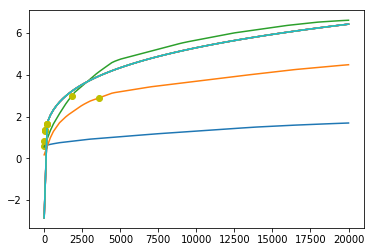

In [12]:
# Plot the 3 ROI curves
plt.figure() 
x = np.linspace(0, x_max, 100) 
for j in range(num_watersheds_total):
    plt.plot(x, roi[j](x), label="ROI %d" % j)
    plt.plot(X[j], roi[j](X[j]), 'yo') # point of actual money invest on this watershed
#plt.legend()

## Verify if solution is optimal with KKT conditions
No need to check dual feasibility because the code guarantees 
that dual variables lambda are always >= 0

In [26]:
print ("\nChecking primal feasibility:")
# Total habitat should be geq target habitat for all species i
for i in range(num_species):
    print ("Total habitat vs. target habitat for species", i, ": ", np.dot(a[i,:], total_habitat), " | ", b[i]) 

print ("\nChecking complementary slackness: y*(b-Af)")
# The product should be zero for all species i
print (y * (b - np.dot(a , total_habitat)), "\n") 
print ("y = ", y)

print("S = ", S)

print ("X = ", X)

f = np.array([roi[j](X[j]) for j in range(num_watersheds_total)])
Af = np.dot(a, f)
print ("\nb - Af + S = ", b - Af + S)

# TODO: check if s and x are geq 0 
print("\nChecking primal variables are positive:")
print("Primal Variables x: ", (X>0).all()) # need to store history of X[j], currently overriding
print("slack variables: ", (S>0).all())


# TODO calculate f_prime 
# research on slack varibale in KKT, okay to drop s in kkt condition
# kkt should satisfy original formulation 

f_prime = np.array([roi_prime[j](X[j]) for j in range(num_watersheds_total)])

print("\nf'(x) * dot(a.T, y)")
print(f_prime * np.dot(a.T, y))




Checking primal feasibility:
Total habitat vs. target habitat for species 0 :  48.68958877992211  |  1.5
Total habitat vs. target habitat for species 1 :  47.83667017051242  |  3.5
Total habitat vs. target habitat for species 2 :  31.60154159520319  |  3.0
Total habitat vs. target habitat for species 3 :  35.752558351684144  |  5.0
Total habitat vs. target habitat for species 4 :  35.36779843114017  |  24.0
Total habitat vs. target habitat for species 5 :  56.50115262801091  |  41.0
Total habitat vs. target habitat for species 6 :  32.56457331121008  |  26.0
Total habitat vs. target habitat for species 7 :  28.774252134844186  |  6.0
Total habitat vs. target habitat for species 8 :  42.11571076119909  |  31.0
Total habitat vs. target habitat for species 9 :  49.909626127113185  |  3.0
Total habitat vs. target habitat for species 10 :  34.68675483160094  |  27.0
Total habitat vs. target habitat for species 11 :  41.45186890409104  |  26.0
Total habitat vs. target habitat for species 12

1. f prime, close to 1 but not 1
2. does a related is roi specific? if we change a, complementary slackness is violated and f_prime a.t y is bad - we think it is related with ROI. cannot find Ngoc's code on her example in slides

## Using scipy.optimize to solve the toy problem 

In [9]:
def objective(x): 
    return sum(x)

# all constraints in our toy problem
def constraint(x):
    cnstrs = np.empty(num_species, dtype=object)
    for i in range(num_species):
        cnstrs[i] = np.dot(a[i,:].T,np.array([roi[j](x[j]) for j in range(num_watersheds_total)])) - b[i]
    return cnstrs


bnd = (0., math.inf) # constraints on x. Here, x_1,...,x_n >= 0.
bnds = (bnd,) * num_watersheds_total # bnds = (bnd, bnd, ..., bnd)


con = {'type': 'ineq', 'fun': constraint} # all constraints

x0 = [0]*num_watersheds_total  # initial guess: x0 = [0, 0, ..., 0]

In [10]:
opt = {'maxiter':2000} # set max # of iterations 

start_time = time.time()
sol = minimize(objective, x0, bounds = bnds, constraints = con, options = opt)

print("\n--- %s seconds ---" % (time.time() - start_time))


--- 643.100438117981 seconds ---


In [12]:
print(sol, '\n')

print('sum x = ', np.sum(sol.x), '\n')

print(constraint(sol.x))

     fun: 4082.265241129728
     jac: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 21476
     nit: 413
    njev: 411
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 6.97277073e-15, 1.52058203e+02,
       3.37427588e+01, 2.47480043e+02, 8.82432883e+01, 1.18124200e+02,
       6.61420233e-15, 8.67092834e+01, 5.83960515e+01, 3.48854743e+01,
       1.73393186e+02, 2.34132548e+01, 1.52035803e+02, 1.34610600e-01,
       5.73407771e-01, 8.82386563e+01, 1.16459793e+02, 2.22525670e+01,
       1.01109274e+02, 2.24092329e+01, 8.64564855e+01, 5.68264138e+01,
       2.08527537e+02, 2.24091441e+01, 2.06584195e+02, 1.71265793e+02,
       5.51559941e+00, 8.82283715e+01, 5.61348749e+00, 3.35602862e+01,
       5.81633224e+01, 4.33303959e+01, 1.

### some numbers 
'''
Make up roi curves
'''

np.random.seed(2032)

'''
Toy problem with 3 watersheds and 3 species
'''

np.random.seed(6873480)

